In [1]:
import numba
import numpy as np
from math import exp, log, e, sqrt
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
J = 1
@numba.jit(nopython=True)
def _update(x, i, j, kT):
    n, m = x.shape
    dE = 2* x[i, j] * (
                     x[(i-1)%n,  j     ]
                   + x[ i     , (j-1)%m]
                   + x[ i     , (j+1)%m]
                   + x[(i+1)%n,  j     ]
                   )
    if (dE <= 0 or exp(-dE / kT) > np.random.random()):
        x[i, j] *= -1

@numba.jit(nopython=True)
def update(x, kT):
    n, m = x.shape

    for i in range(n):
        for j in range(0, m, 2):  # Even columns first to avoid overlap
            _update(x, i, j, kT)

    for i in range(n):
        for j in range(1, m, 2):  # Odd columns second to avoid overlap
            _update(x, i, j, kT)
    
    iene = 0
    stot = 0
    
    for i in range(n):
        for j in range(m):
            stot += x[i, j]
            iene += x[i, j]*x[(i+1)%n, j] 
            iene += x[i, j]*x[i, (j+1)%m]
            
    iene = (-iene*J)/(n*m)
    stot = stot/(n*m)
    
    return iene, stot

if __name__ == '__main__':
    magnetization = []
    for kT in np.arange(2.0, 2.5, 0.02):
        energy =[]
        magnet = []
        x = np.random.randint(2, size=(64, 64)).astype('i1')
        x[x == 0] = -1
        for i in range(100000):
            E, M = update(x, kT)
            energy.append(E)
            magnet.append(M)

        magnetization.append(magnet[10000:])

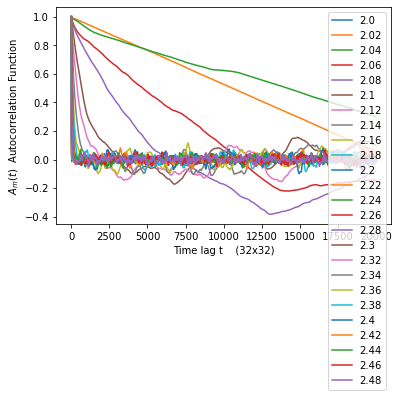

[3, 3, 3, 3, 4, 6, 7, 9, 19, 16, 24, 13350, 18035, 6308, 3189, 903, 536, 275, 150, 115, 81, 62, 46, 37, 31]


In [3]:
def find_nearest(array, value):     
    array = np.asarray(array);
    idx = (np.abs(array - value)).argmin();
    return idx;

temps = []
autocorrtime=[]
for i in np.arange(0, len(magnetization)):
    idk = sm.tsa.acf(magnetization[i], nlags=20000, fft = False)
    autocorrtime.append(find_nearest(idk, 1/e))
    plt.ylabel(r'$A_m(t)$' + "  Autocorrelation Function")
    plt.xlabel('Time lag t    (32x32)')
    plt.plot(idk, '-')
    
    temps.append(round(2+i*0.02,2))
    
    
    
plt.legend(temps)
plt.show()
print(autocorrtime)

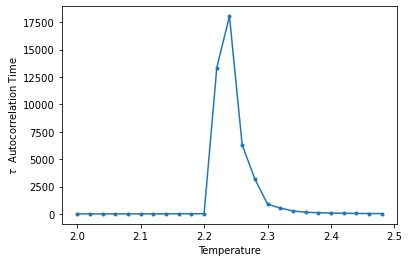

In [4]:
plt.ylabel(r'$\tau$' + "  Autocorrelation Time")
plt.xlabel('Temperature')
plt.plot(temps, autocorrtime, '.-')
plt.show()